![title](https://raw.githubusercontent.com/google/eng-edu/main/ml/recommendation-systems/images/softmax-model.png)

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
os.chdir('..')

In [3]:
train_df = pd.read_parquet('data/splits/train.parquet')
print(train_df.shape)
train_df.head()

(30143457, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2.0
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2.0
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2.0
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2.0
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2.0


In [4]:
train_df.sort_values(['customer_id', 't_dat'], inplace=True)

In [5]:
articles_df = pd.read_csv('data/articles.csv', dtype={'article_id': str})  # Make sure article_id is being loading in as a string
print(articles_df.shape)
articles_df.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [6]:
customers_df = pd.read_csv('data/customers.csv')
print(customers_df.shape)
customers_df.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [7]:
customers_df.isnull().sum() / customers_df.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

### fashrec-v1

- Use order history only
- Embedding for each item
- If item ordered X times index its embedding X times
- BoW of all item history embeddings
- For each customer take random transaction and roll-back data

In [8]:
train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
4212358,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0625548001,0.044051,1.0
4212359,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0176209023,0.035576,1.0
4212360,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0627759010,0.030492,1.0
9663224,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0697138006,0.010153,2.0
10754876,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006,0.050831,2.0


In [9]:
train_df['total_purchases'] = train_df.groupby('customer_id')['article_id'].transform('count')

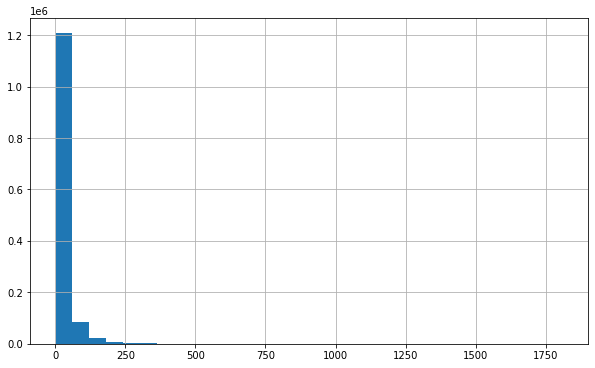

In [10]:
plt.figure(figsize=(10, 6))
train_df[['customer_id', 'total_purchases']].drop_duplicates()['total_purchases'].hist(bins=30)
plt.show()

In [11]:
train_df['customer_id'].nunique()

1328797

In [12]:
# Prop. of customers with only a single purchase
train_df[train_df['total_purchases'] == 1].shape[0] / train_df['customer_id'].nunique()

0.09628332995935421

These customers will be cold start customers with no order history

In [13]:
train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,total_purchases
4212358,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0625548001,0.044051,1.0,20
4212359,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0176209023,0.035576,1.0,20
4212360,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0627759010,0.030492,1.0,20
9663224,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0697138006,0.010153,2.0,20
10754876,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006,0.050831,2.0,20


In [14]:
train_df.reset_index(drop=True, inplace=True)

In [15]:
train_df['uid'] = train_df.index

In [16]:
train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,total_purchases,uid
0,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0625548001,0.044051,1.0,20,0
1,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0176209023,0.035576,1.0,20,1
2,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0627759010,0.030492,1.0,20,2
3,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0697138006,0.010153,2.0,20,3
4,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006,0.050831,2.0,20,4


In [17]:
labels = train_df[['customer_id', 'uid']].groupby('customer_id').sample(n=1, random_state=3)

In [18]:
labels.head()

,customer_id,uid
14,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,14
39,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,39
122,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,122
123,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,123
131,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,131


In [19]:
labels['label'] = 1

In [20]:
train_df = train_df.merge(labels, on=['customer_id', 'uid'], how='left')

In [21]:
train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,total_purchases,uid,label
0,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0625548001,0.044051,1.0,20,0,NaN
1,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0176209023,0.035576,1.0,20,1,NaN
2,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0627759010,0.030492,1.0,20,2,NaN
3,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0697138006,0.010153,2.0,20,3,NaN
4,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006,0.050831,2.0,20,4,NaN


In [22]:
train_df['keep'] = train_df['label'].copy()

In [23]:
train_df['keep'] = train_df.groupby('customer_id')['keep'].bfill()

In [24]:
# Drop records for each customer after the label
train_df = train_df.copy()[train_df['keep'] == 1]

In [25]:
train_df['label'].fillna(0, inplace=True)

In [26]:
train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,total_purchases,uid,label,keep
0,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0625548001,0.044051,1.0,20,0,0.0,1.0
1,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0176209023,0.035576,1.0,20,1,0.0,1.0
2,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0627759010,0.030492,1.0,20,2,0.0,1.0
3,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0697138006,0.010153,2.0,20,3,0.0,1.0
4,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006,0.050831,2.0,20,4,0.0,1.0


In [27]:
train_df.drop(columns=['uid', 'keep', 'total_purchases'], inplace=True)

In [28]:
train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,label
0,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0625548001,0.044051,1.0,0.0
1,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0176209023,0.035576,1.0,0.0
2,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0627759010,0.030492,1.0,0.0
3,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0697138006,0.010153,2.0,0.0
4,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006,0.050831,2.0,0.0


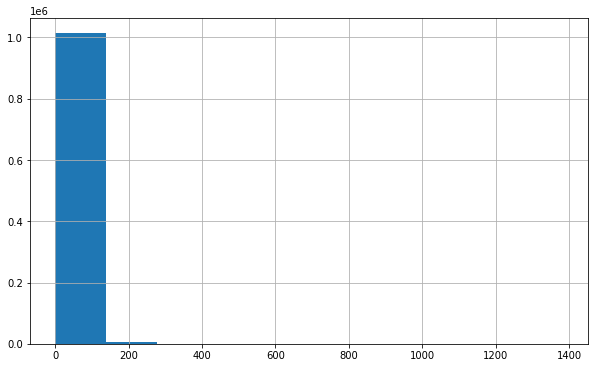

In [29]:
# Dist. of historical orders
plt.figure(figsize=(10, 6))
train_df[train_df['label'] == 0].groupby('customer_id')['article_id'].count().hist()
plt.show()

In [30]:
train_df[train_df['label'] == 0].groupby('customer_id')['article_id'].count().describe()

count    1.020568e+06
mean     1.410742e+01
std      2.500683e+01
min      1.000000e+00
25%      2.000000e+00
50%      6.000000e+00
75%      1.500000e+01
max      1.382000e+03
Name: article_id, dtype: float64

In [31]:
train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,label
0,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0625548001,0.044051,1.0,0.0
1,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0176209023,0.035576,1.0,0.0
2,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0627759010,0.030492,1.0,0.0
3,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0697138006,0.010153,2.0,0.0
4,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006,0.050831,2.0,0.0


- Map `article_id` to an index
- Create inputs and labels for each customer

In [32]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [33]:
articles_df['article_id'].nunique(), articles_df.shape[0]

(105542, 105542)

Create additional `article_id`=-1 which maps to `1`. This will be used when a customer has no order history (cold-start)

In [34]:
article_id_to_idx = dict(
    zip(
        articles_df['article_id'],
        articles_df.index + 2
    )
)

In [35]:
article_id_to_idx['-1'] : 1

In [36]:
train_df['article_id_idx'] = train_df['article_id'].map(article_id_to_idx)

In [37]:
train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,label,article_id_idx
0,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0625548001,0.044051,1.0,0.0,29518
1,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0176209023,0.035576,1.0,0.0,101
2,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0627759010,0.030492,1.0,0.0,30329
3,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0697138006,0.010153,2.0,0.0,50726
4,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006,0.050831,2.0,0.0,16005


In [38]:
# How many items do not appear in the training set?
len(set(articles_df['article_id']) - set(train_df['article_id']))

9878

In [39]:
from torch.nn.utils.rnn import pad_sequence

In [40]:
from torch.utils.data import Dataset


NO_PURCHASE_HISTORY_IDX = 1

PADDING_VALUE = 0


class NextCharacterDataset(Dataset):

    def __init__(self, input_df):
        """
        """
        input_df['total_purchases'] = input_df.groupby('customer_id')['article_id'].transform('count')

        # Have purchase history

        have_purchase_history_customers = input_df.copy()[input_df['total_purchases'] != 1]

        labels = have_purchase_history_customers.copy()[
            have_purchase_history_customers['label'] == 1
        ][['customer_id', 'article_id_idx']]

        historical_purchases = (
            have_purchase_history_customers.copy()[have_purchase_history_customers['label'] == 0]
            .groupby('customer_id')['article_id_idx']
            .apply(lambda x: list(x))  # Create a list of purchases per customer
            .reset_index()
            .rename(columns={'article_id_idx': 'history'})
        )

        combined = historical_purchases.merge(labels, on='customer_id')
        
        customers = combined['customer_id'].tolist()

        sequences = [torch.tensor(l) for l in combined['history'].values.tolist()]

        padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=PADDING_VALUE)

        dim_after_padding = padded_sequences.shape[1]

        labels_tensor = torch.tensor(combined['article_id_idx'].values.tolist())

        # No purchase history

        no_purchase_history_customers = input_df.copy()[input_df['total_purchases'] == 1]
        
        customers_no_purch = no_purchase_history_customers['customer_id'].tolist()

        number_of_no_purch = no_purchase_history_customers.shape[0]

        labels_no_purch = torch.tensor(no_purchase_history_customers['article_id_idx'].values.tolist())

        padded_sequences_no_purch = torch.ones((number_of_no_purch, dim_after_padding)) * PADDING_VALUE
        padded_sequences_no_purch[:, 0] = NO_PURCHASE_HISTORY_IDX

        # Create X, y

        self.X = torch.concat([padded_sequences, padded_sequences_no_purch], dim=0)
        self.y = torch.concat([labels_tensor, labels_no_purch])
        self.customer_id_list = customers
        self.customer_id_list += customers_no_purch

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return self.X[idx, :], self.y[idx], self.customer_id_list[idx]

In [41]:
%%time
next_character_dataset = NextCharacterDataset(train_df)

CPU times: user 58.6 s, sys: 49.4 s, total: 1min 48s
Wall time: 1min 25s


Check

In [42]:
# # No purchase history
# sample_customer_id = train_df[train_df['total_purchases'] == 1].sample(n=1)['customer_id'].item()

# Purchase history
sample_customer_id = train_df[train_df['total_purchases'] != 1].sample(n=1)['customer_id'].item()

sample_customer_id

'58d384940abb6ad90ad58d94c86bacf39bd47d0ee8f1323f39ac38e3c8a3dbbf'

In [43]:
idx = next_character_dataset.customer_id_list.index(sample_customer_id)
idx

353977

In [44]:
dataset_items = [v for v in next_character_dataset.X[idx].tolist() if v != 0]
dataset_items = set(dataset_items)
dataset_items

{233.0,
 1555.0,
 2469.0,
 6643.0,
 8160.0,
 11601.0,
 11808.0,
 12736.0,
 14088.0,
 16699.0,
 19592.0,
 24269.0,
 24272.0,
 29097.0,
 30902.0,
 32560.0,
 33205.0,
 38407.0,
 38534.0,
 39270.0,
 40382.0,
 41026.0,
 42111.0,
 42488.0,
 43032.0,
 43105.0,
 44402.0,
 44594.0,
 47411.0,
 47647.0,
 47689.0,
 48049.0,
 48052.0,
 49924.0,
 50613.0,
 50837.0,
 52453.0,
 54844.0,
 56449.0,
 57546.0,
 60129.0,
 61050.0,
 63387.0,
 65672.0,
 66915.0,
 69673.0,
 69793.0,
 73364.0,
 73560.0,
 76891.0,
 81102.0,
 90346.0,
 92138.0}

In [45]:
expected_items = set(
    train_df[
        (train_df['customer_id'] == sample_customer_id) &
        (train_df['label'] == 0)
    ]['article_id_idx'].tolist()
)

In [46]:
expected_items == dataset_items  # Should be true for customers with purchase history

True

In [47]:
dataset_label = next_character_dataset.y[idx].item()
expected_label = train_df[
    (train_df['customer_id'] == sample_customer_id) &
    (train_df['label'] == 1)
]['article_id_idx'].item()

dataset_label == expected_label

True

### Dev data prep

In [48]:
dev_df = pd.read_parquet('data/splits/dev.parquet')
print(dev_df.shape)
dev_df.head()

(277388, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-08-10,00045027219e894b683fb4687211e2d0c904c268e9f28d...,0832481001,0.016932,1.0
1,2020-08-10,00045027219e894b683fb4687211e2d0c904c268e9f28d...,0907696001,0.016932,1.0
2,2020-08-10,00058592fc65afabbb00b1bb7d33c6b221d00c6a98c621...,0829152002,0.030492,2.0
3,2020-08-10,00058592fc65afabbb00b1bb7d33c6b221d00c6a98c621...,0812668001,0.050831,2.0
4,2020-08-10,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,0887770002,0.008458,2.0


In [49]:
dev_df['article_id_idx'] = dev_df['article_id'].map(article_id_to_idx)

In [50]:
dev_df_by_customer = dev_df.groupby('customer_id').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'actual_purchases'})
dev_df_by_customer.head()

,customer_id,actual_purchases
0,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[101369, 60765, 104814, 77917]"
1,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,"[99403, 104304, 53894, 98869]"
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"[101855, 101855, 91582, 91583, 91584, 85622, 8..."
3,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,"[75445, 75440, 67524]"
4,0002db27a1651998a3de4463437b580b45dfa7d8107afa...,[104741]


In [51]:
train_df_full = pd.read_parquet('data/splits/train.parquet')
train_df_full.sort_values(['customer_id', 't_dat'], inplace=True)
print(train_df_full.shape)
train_df_full.head()

(30143457, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
4212358,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0625548001,0.044051,1.0
4212359,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0176209023,0.035576,1.0
4212360,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0627759010,0.030492,1.0
9663224,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0697138006,0.010153,2.0
10754876,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006,0.050831,2.0


In [52]:
train_df_full['article_id_idx'] = train_df_full['article_id'].map(article_id_to_idx)

In [53]:
train_df_full.head()

,t_dat,customer_id,article_id,price,sales_channel_id,article_id_idx
4212358,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0625548001,0.044051,1.0,29518
4212359,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0176209023,0.035576,1.0,101
4212360,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0627759010,0.030492,1.0,30329
9663224,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0697138006,0.010153,2.0,50726
10754876,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006,0.050831,2.0,16005


In [54]:
historical_purchases = (
    train_df_full
    .groupby('customer_id')['article_id_idx']
    .apply(lambda x: list(x))  # Create a list of purchases per customer
    .reset_index()
    .rename(columns={'article_id_idx': 'history'})
)

In [55]:
historical_purchases.head()

,customer_id,history
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[29518, 101, 30329, 50726, 16005, 16005, 23998..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[19335, 33750, 33993, 8218, 41026, 19335, 4262..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[40181, 10522, 40181, 18199, 59460, 1471, 1471..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"[64527, 61177]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[32249, 43444, 51126, 54463, 2183, 2183, 20519..."


In [56]:
dev_df_by_customer = dev_df_by_customer.merge(historical_purchases, on='customer_id', how='left', indicator=True)
dev_df_by_customer.head()

,customer_id,actual_purchases,history,_merge
0,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[101369, 60765, 104814, 77917]","[32249, 43444, 51126, 54463, 2183, 2183, 20519...",both
1,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,"[99403, 104304, 53894, 98869]","[17158, 41599, 35803, 17152, 35801, 47421, 475...",both
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,"[101855, 101855, 91582, 91583, 91584, 85622, 8...","[16166, 16166, 39929, 8343, 930, 41146, 44864,...",both
3,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,"[75445, 75440, 67524]","[40347, 53100, 31712, 19015, 19015, 10526, 105...",both
4,0002db27a1651998a3de4463437b580b45dfa7d8107afa...,[104741],"[25872, 47425, 2228, 60859, 3569, 67624, 47416...",both


In [57]:
dev_df_by_customer['_merge'].value_counts() / dev_df_by_customer.shape[0]

both          0.935266
left_only     0.064734
right_only    0.000000
Name: _merge, dtype: float64

With history

In [58]:
dev_df_by_customer_with_history = dev_df_by_customer.copy()[dev_df_by_customer['_merge'] == 'both']

In [59]:
max_history_length = next_character_dataset.X.shape[1]
max_history_length

1382

In [60]:
dev_df_by_customer_with_history['history'] = dev_df_by_customer_with_history['history'].apply(lambda x: x[:max_history_length])

In [61]:
sequences = [torch.tensor(l) for l in dev_df_by_customer_with_history['history'].values.tolist()]

padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=PADDING_VALUE)

In [62]:
padded_sequences.shape

torch.Size([67443, 1382])

No history

In [63]:
dev_df_by_customer_no_history = dev_df_by_customer.copy()[dev_df_by_customer['_merge'] == 'left_only']

In [64]:
padded_sequences_no_purch = torch.ones((dev_df_by_customer_no_history.shape[0], max_history_length)) * PADDING_VALUE
padded_sequences_no_purch[:, 0] = NO_PURCHASE_HISTORY_IDX

In [65]:
padded_sequences_no_purch.shape

torch.Size([4668, 1382])

In [66]:
dev_df_by_customer = dev_df_by_customer_with_history.append(dev_df_by_customer_no_history)
dev_df_by_customer.shape

/var/folders/y7/s4mqr2gn1xs617jmcj6fc_ph0000gn/T/ipykernel_57685/3368644721.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dev_df_by_customer = dev_df_by_customer_with_history.append(dev_df_by_customer_no_history)


(72111, 4)

In [67]:
dev_padded_sequences = torch.concat([padded_sequences, padded_sequences_no_purch], dim=0)
dev_padded_sequences.shape

torch.Size([72111, 1382])

### Train model

In [232]:
class FashionRecV1(nn.Module):

    def __init__(self, mask_value, embedding_dim):
        super(FashionRecV1, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(num_embeddings=len(article_id_to_idx), embedding_dim=self.embedding_dim)
        
        self.fc_1 = nn.Linear(in_features=self.embedding_dim, out_features=11)
        
        self.fc_2 = nn.Linear(in_features=11, out_features=len(article_id_to_idx))
        
        self.relu = nn.ReLU()
        
        self.tanh = nn.Tanh()
        
        self.mask_value = mask_value

    def forward(self, padded_sequences):
        
        x = self.embedding(padded_sequences)

        mask = padded_sequences != self.mask_value
        
        # Repeat mask so that shape matches output of embedding
        mask = torch.unsqueeze(mask, dim=2)
        mask = mask.repeat(1, 1, self.embedding_dim)

        x = mask * x
        
        # Compute average over non-padding embeddings:
        x = x.sum(dim=1)
        num_embeddings = mask[:, :, 0].sum(dim=1).reshape(-1, 1)  # Divide by number of (non-padding) embeddings to get mean embedding

        x = torch.div(
            x, 
            num_embeddings
        )

        x = self.fc_1(x)
        x = self.relu(x)
        
        x = self.fc_2(x)
        x = self.tanh(x)
        
        return x

In [233]:
fashion_rec_v1 = FashionRecV1(mask_value=PADDING_VALUE, embedding_dim=100)

In [234]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v1.parameters(), lr=0.01)

In [235]:
data_loader_train = DataLoader(next_character_dataset, batch_size=32, shuffle=True)

In [260]:
losses = []

for epoch in range(1):
    for idx, data in enumerate(tqdm(data_loader_train)):
        
        X, y, _ = data
        X = X.long()

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v1(X)
        
        loss = criterion(y_pred, y)  # Need index for loss in PyTorch

        loss.backward()
        
        losses.append(loss.item())
        
        optimizer.step()      

 12%|████████████████▎                                                                                                                  | 5184/41525 [10:26<1:13:11,  8.27it/s]


KeyboardInterrupt: 

In [261]:
with torch.no_grad():
    dev_logits = fashion_rec_v1(dev_padded_sequences[:100, :].long())

In [262]:
dev_logits

tensor([[-1.0000, -1.0000,  0.9991,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9991,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9991,  ..., -1.0000, -1.0000, -1.0000],
        ...,
        [-1.0000, -1.0000,  0.9991,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9991,  ..., -1.0000, -1.0000, -1.0000],
        [-1.0000, -1.0000,  0.9991,  ..., -1.0000, -1.0000, -1.0000]])

In [263]:
dev_top_12_article_idx = dev_logits.argsort(dim=1, descending=True)[:, :12]
print(dev_top_12_article_idx.shape)
dev_top_12_article_idx

torch.Size([100, 12])


tensor([[53894,  1715,  1471,  ...,  2254, 42559, 45793],
        [53894,  1715,  1471,  ...,  2254, 42559, 45793],
        [53894,  1715,  1471,  ...,  2254, 42559, 45793],
        ...,
        [53894,  1715,  1471,  ...,  2254, 42559, 45793],
        [53894,  1715,  1471,  ...,  2254, 42559, 45793],
        [53894,  1715,  1471,  ...,  2254, 42559, 45793]])

In [264]:
dev_top_12_article_idx_list = dev_top_12_article_idx.tolist()

In [265]:
actuals = dev_df_by_customer.head(100)['actual_purchases'].tolist()

In [266]:
from fashion_recommendations.metrics.average_precision import mapk

In [267]:
mapk(actuals, dev_top_12_article_idx_list, k=12)

0.008035714285714287

TODO:
- Monitor dev MAP@k during training
- Move to Colab

Take sample of training examples

In [39]:
train_df.shape

(15726381, 7)

In [40]:
sample_customers = train_df[['customer_id']].drop_duplicates()['customer_id'].sample(n=10, random_state=3).to_list()

In [41]:
train_df = train_df.copy()[train_df['customer_id'].isin(sample_customers)]

In [42]:
train_df.shape

(124, 7)

In [43]:
train_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,label,article_id_idx
26196,2020-03-18,003b9944273268bb0ae1586de5c51b9b01d7ece251cb33...,0884750001,0.025407,2.0,0.0,99484
26197,2020-03-18,003b9944273268bb0ae1586de5c51b9b01d7ece251cb33...,0884750001,0.025407,2.0,1.0,99484
2506551,2020-08-06,153352be7dad0fed65326a49096c896a39fbf01533ee11...,0737221009,0.016932,2.0,0.0,62746
2506552,2020-08-06,153352be7dad0fed65326a49096c896a39fbf01533ee11...,0757971006,0.022017,2.0,0.0,69725
2506553,2020-08-06,153352be7dad0fed65326a49096c896a39fbf01533ee11...,0737221011,0.016932,2.0,1.0,62748


If `customer_id` has purchases before label, these are the inputs for that customer.

If `customer_id` has no purchases before label we give an input of `0`.

Pad all inputs to a fixed length (for inference we can remove any items purchases which cause this length to be exceeded).

During training create a padding mask and take mean over historical purchase embeddings.

In [44]:
labels = train_df.copy()[train_df['label'] == 1][['customer_id', 'article_id_idx']]
labels

,customer_id,article_id_idx
26197,003b9944273268bb0ae1586de5c51b9b01d7ece251cb33...,99484
2506553,153352be7dad0fed65326a49096c896a39fbf01533ee11...,62748
4919700,29a005aa7535c59257283be998b599c621e1f5f6a82e1b...,36731
5745091,309cb7c1c9f33c93d80bb36b3cc4cf05e83e66793595e2...,1038
10415238,58765ce1fcafeca8159795e574968951ec5ffea61f6f87...,88143
12092711,669e9d0aeabaca6013f1ecc9b41c1655e2cc141cb669a8...,93110
18994087,a10764c8e32ca80080271ae1fc50f8ff6277fed688e7c6...,10111
20034343,a9d7d074f31baed0800cdfe5235348bdd36953f953111a...,16019
23212247,c50109e9c7f19dc7453719111e0dce19edcc1e94cb52cd...,31296
25252049,d64668c89baf85da23f3c6426f889e926c30b0d9ab5d70...,61786


In [45]:
historical_purchases = train_df.groupby('customer_id')['article_id_idx'].apply(lambda x: list(x)).reset_index().rename(columns={'article_id_idx': 'history'})
historical_purchases

,customer_id,history
0,003b9944273268bb0ae1586de5c51b9b01d7ece251cb33...,"[99484, 99484]"
1,153352be7dad0fed65326a49096c896a39fbf01533ee11...,"[62746, 69725, 62748]"
2,29a005aa7535c59257283be998b599c621e1f5f6a82e1b...,"[8592, 8592, 21363, 16906, 48232, 22759, 40260..."
3,309cb7c1c9f33c93d80bb36b3cc4cf05e83e66793595e2...,"[42480, 42480, 7407, 130, 29099, 11566, 39599,..."
4,58765ce1fcafeca8159795e574968951ec5ffea61f6f87...,[88143]
5,669e9d0aeabaca6013f1ecc9b41c1655e2cc141cb669a8...,"[54145, 47083, 53773, 62534, 50659, 44622, 258..."
6,a10764c8e32ca80080271ae1fc50f8ff6277fed688e7c6...,"[67031, 37239, 41098, 67460, 10111]"
7,a9d7d074f31baed0800cdfe5235348bdd36953f953111a...,[16019]
8,c50109e9c7f19dc7453719111e0dce19edcc1e94cb52cd...,"[3725, 4223, 16720, 25838, 4724, 42385, 45569,..."
9,d64668c89baf85da23f3c6426f889e926c30b0d9ab5d70...,[61786]


In [46]:
combined = historical_purchases.merge(labels, on='customer_id')
combined

,customer_id,history,article_id_idx
0,003b9944273268bb0ae1586de5c51b9b01d7ece251cb33...,"[99484, 99484]",99484
1,153352be7dad0fed65326a49096c896a39fbf01533ee11...,"[62746, 69725, 62748]",62748
2,29a005aa7535c59257283be998b599c621e1f5f6a82e1b...,"[8592, 8592, 21363, 16906, 48232, 22759, 40260...",36731
3,309cb7c1c9f33c93d80bb36b3cc4cf05e83e66793595e2...,"[42480, 42480, 7407, 130, 29099, 11566, 39599,...",1038
4,58765ce1fcafeca8159795e574968951ec5ffea61f6f87...,[88143],88143
5,669e9d0aeabaca6013f1ecc9b41c1655e2cc141cb669a8...,"[54145, 47083, 53773, 62534, 50659, 44622, 258...",93110
6,a10764c8e32ca80080271ae1fc50f8ff6277fed688e7c6...,"[67031, 37239, 41098, 67460, 10111]",10111
7,a9d7d074f31baed0800cdfe5235348bdd36953f953111a...,[16019],16019
8,c50109e9c7f19dc7453719111e0dce19edcc1e94cb52cd...,"[3725, 4223, 16720, 25838, 4724, 42385, 45569,...",31296
9,d64668c89baf85da23f3c6426f889e926c30b0d9ab5d70...,[61786],61786


In [47]:
sequences = [torch.tensor(l) for l in combined['history'].values.tolist()]
sequences

[tensor([99484, 99484]),
 tensor([62746, 69725, 62748]),
 tensor([ 8592,  8592, 21363, 16906, 48232, 22759, 40260, 28243, 28243, 30890,
         30890, 30890,  3034,  3034,  3034, 24372, 44233, 36756, 23068, 13735,
         13735, 45792, 45792, 45792, 61684, 61684, 57850, 57850, 57850, 45795,
         45795, 22642, 45797, 45797, 57846, 57846, 13737, 45793, 57850, 58693,
         40523,  2228,  2228, 59272, 34110, 43697, 79680, 43471, 74510, 47927,
         22003, 75440, 75440, 36731]),
 tensor([42480, 42480,  7407,   130, 29099, 11566, 39599, 13824, 19431, 22182,
         17282, 13800,  1038]),
 tensor([88143]),
 tensor([ 54145,  47083,  53773,  62534,  50659,  44622,  25893,  53547,  65751,
          53774,  43963,  54144,  25891,  44505,  45017,  35319,  54295,  55325,
          50658,  83214,  79011,  94326,  84905,  93213,  99018,  99018, 102026,
          94370,  94376,  99706,  93110]),
 tensor([67031, 37239, 41098, 67460, 10111]),
 tensor([16019]),
 tensor([ 3725,  4223, 16720, 

In [48]:
from torch.nn.utils.rnn import pad_sequence

In [46]:
PADDING_VALUE = 0

x = torch.ones((20, 54)) * PADDING_VALUE

In [47]:
x[:, 0] = 1

In [48]:
x

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [50]:
torch.concat([x, x], dim=0).shape

torch.Size([40, 54])

In [49]:
PADDING_VALUE = 0

padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=PADDING_VALUE)
padded_sequences.shape

torch.Size([10, 54])

In [50]:
labels_tensor = torch.tensor(combined['article_id_idx'].values.tolist())
labels_tensor.shape

torch.Size([10])

In [137]:
len(article_id_to_idx)

105542

In [138]:
embedding = nn.Embedding(num_embeddings=len(article_id_to_idx), embedding_dim=5, padding_idx=PADDING_VALUE)

In [139]:
x = embedding(padded_sequences)
x.shape

torch.Size([10, 54, 5])

In [140]:
mask = padded_sequences != 0
mask.shape

torch.Size([10, 54])

In [141]:
mask = torch.unsqueeze(mask, dim=2)
mask.shape

torch.Size([10, 54, 1])

In [142]:
mask = mask.repeat(1, 1, 5)
mask.shape

torch.Size([10, 54, 5])

In [143]:
x = mask * x
x.shape

torch.Size([10, 54, 5])

In [144]:
x = x.sum(dim=1)
x.shape

torch.Size([10, 5])

In [145]:
num_embeddings = mask[:, :, 0].sum(dim=1).reshape(-1, 1)
num_embeddings

tensor([[ 2],
        [ 3],
        [54],
        [13],
        [ 1],
        [31],
        [ 5],
        [ 1],
        [13],
        [ 1]])

In [146]:
# Divide by number of (non-padding) embeddings to get mean embedding
x = torch.div(
    x, 
    num_embeddings
)
x.shape

torch.Size([10, 5])

In [148]:
x

tensor([[-0.6357, -1.7933, -0.2005,  0.5743,  0.5712],
        [ 0.2403,  0.2913, -0.7017,  0.0430, -0.0364],
        [ 0.2085,  0.2021, -0.3339,  0.0913,  0.1031],
        [ 0.7454,  0.3456,  0.1706, -0.1254, -0.5056],
        [ 1.6709, -1.0495,  0.1992, -0.5639, -2.3281],
        [-0.0711, -0.1460,  0.1410,  0.1145,  0.1643],
        [ 0.0271, -0.1231,  0.2741, -0.3421, -0.2489],
        [ 0.1726,  0.2074, -2.0166,  0.3091, -0.6436],
        [ 0.2648,  0.1692,  0.2662,  0.0776, -0.0558],
        [-0.9304,  0.0221, -1.4261,  0.2721,  0.7763]], grad_fn=<DivBackward0>)

In [51]:
class FashionRecv1(nn.Module):

    def __init__(self, mask_value, embedding_dim):
        super(FashionRecv1, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        self.embedding = nn.Embedding(num_embeddings=len(article_id_to_idx), embedding_dim=self.embedding_dim)
        
        self.fc_1 = nn.Linear(in_features=self.embedding_dim, out_features=11)
        
        self.fc_2 = nn.Linear(in_features=11, out_features=len(article_id_to_idx))
        
        self.relu = nn.ReLU()
        
        self.mask_value = mask_value

    def forward(self, padded_sequences):
        
        x = self.embedding(padded_sequences)

        mask = padded_sequences != self.mask_value
        
        # Repeat mask so that shape matches output of embedding
        mask = torch.unsqueeze(mask, dim=2)
        mask = mask.repeat(1, 1, self.embedding_dim)

        x = mask * x
        
        # Compute average over non-padding embeddings:
        x = x.sum(dim=1)
        num_embeddings = mask[:, :, 0].sum(dim=1).reshape(-1, 1)  # Divide by number of (non-padding) embeddings to get mean embedding

        x = torch.div(
            x, 
            num_embeddings
        )

        x = self.fc_1(x)
        x = self.relu(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        
        return x

In [99]:
fashion_rec_v1 = FashionRecv1(mask_value=PADDING_VALUE, embedding_dim=100)

In [100]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v1.parameters(), lr=0.1)

In [101]:
padded_sequences_basic = torch.tensor(
    [[1, 2, 3, 0, 0, 0, 0], [2, 1, 1, 3, 0, 0, 0]]
)

padded_sequences_basic

tensor([[1, 2, 3, 0, 0, 0, 0],
        [2, 1, 1, 3, 0, 0, 0]])

In [102]:
labels_tensor_basic = torch.tensor([3, 2])
labels_tensor_basic

tensor([3, 2])

In [103]:
loss_list = []

for idx, epoch in enumerate(range(1000)):

    optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

#     y_pred = fashion_rec_v1(padded_sequences)

#     loss = criterion(y_pred, labels_tensor)  # Need index for loss in PyTorch

    y_pred = fashion_rec_v1(padded_sequences_basic)

    loss = criterion(y_pred, labels_tensor_basic)  # Need index for loss in PyTorch
    
    loss.backward()
    
    if idx % 100 == 0:
        print(loss.item())
        
    loss_list.append(loss.item())

    optimizer.step()

11.549995422363281
9.136945300269872e-05
6.842378934379667e-05
5.251031325315125e-05
4.0649541915627196e-05
3.194758028257638e-05
2.557006519054994e-05
2.0801804566872306e-05
1.7165990357170813e-05
1.4364615708473139e-05


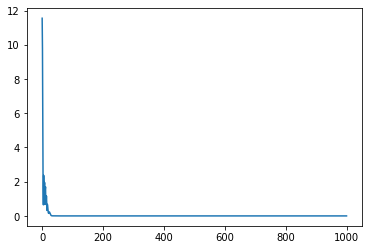

In [104]:
plt.plot(loss_list)